<a href="https://colab.research.google.com/github/olonok69/LLM_Notebooks/blob/main/t5/T5_sequence_to_sequence_custom_mlflow_fine_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#MLFLOW
https://mlflow.org/docs/latest/introduction/index.html


MLflow is a solution to many of these issues in this dynamic landscape, offering tools and simplifying processes to streamline the ML lifecycle and foster collaboration among ML practitioners.

https://mlflow.org/docs/latest/llms/llm-evaluate/index.html

# MLflow transformers Guide
https://mlflow.org/docs/latest/llms/transformers/guide/index.html
https://mlflow.org/docs/latest/llms/transformers/tutorials/fine-tuning/transformers-fine-tuning.html

# T5forConditionalGeneration
T5Model contains the encoder (stack of encoder layers) and decoder (stack of decoder layers) without any task specific heads. It returns the raw hidden states of the decoder as output.

T5ForConditionalGeneration also contains the encoder and decoder and adds an additional linear layer (lm_head) which takes the final hidden states of decoder and generates the next token.

For fine-tuning the model for seq2seq generation you should use T5ForConditionalGeneration, if you want to add some different task specific head then you can T5Model.

# ngrok
Connect localhost to the internet for testing applications and APIs
Bring secure connectivity to apps and APIs in localhost and dev/test environments with just one command or function call.
- Webhook testing
- Developer Previews
- Mobile backend testing

https://ngrok.com/


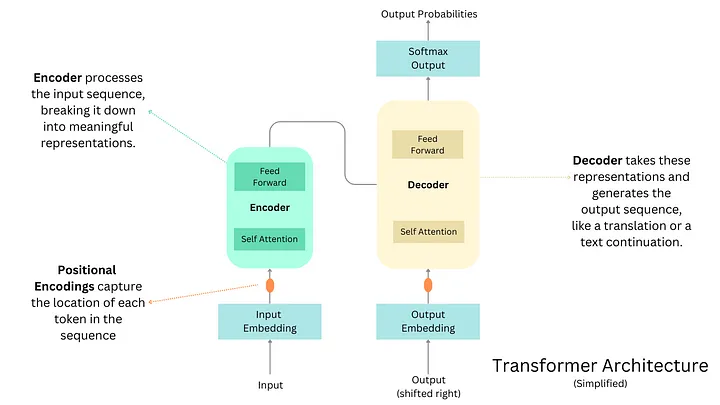

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install mlflow pyngrok evaluate  bitsandbytes accelerate datasets transformers==4.39.3 --quiet
get_ipython().system_raw("mlflow ui --port 5000 &")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.2/20.2 MB 48.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 12.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.8/119.8 MB 14.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.6/297.6 kB 30.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 52.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.8/8.8 MB 106.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 101.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 27.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.6/147.6 kB 21.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 28.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.2/128.2 kB 16.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.2/80.2 kB 12.2 MB/s eta 0:00:00
     ━━━━━━━━━━━

In [3]:

from pyngrok import ngrok
from getpass import getpass

# Terminate open tunnels if exist
ngrok.kill()

In [4]:
from google.colab import userdata
NGROK_AUTH_TOKEN  = userdata.get('NGROK')

ngrok.set_auth_token(NGROK_AUTH_TOKEN)

# Open an HTTPs tunnel on port 5000 for http://localhost:5000
ngrok_tunnel = ngrok.connect(addr="5000", proto="http", bind_tls=True)
print("MLflow Tracking UI:", ngrok_tunnel.public_url)

MLflow Tracking UI: https://c0a9-34-125-29-180.ngrok-free.app


## Fine-Tuning Transformers with MLflow for Enhanced Model Management



In [91]:
# Disable tokenizers warnings when constructing pipelines
%env TOKENIZERS_PARALLELISM=false

import warnings

# Disable a few less-than-useful UserWarnings from setuptools and pydantic
warnings.filterwarnings("ignore", category=UserWarning)

env: TOKENIZERS_PARALLELISM=false


### Preparing the Dataset and Environment for Fine-Tuning

#### Key Steps in this Section

1. **Loading the Dataset**: Utilizing the `sms_spam` dataset for spam detection.
2. **Splitting the Dataset**: Dividing the dataset into training and test sets with an 80/20 distribution.
3. **Importing Necessary Libraries**: Including libraries like `evaluate`, `mlflow`, `numpy`, and essential components from the `transformers` library.

Before diving into the fine-tuning process, setting up our environment and preparing the dataset is crucial. This step involves loading the dataset, splitting it into training and testing sets, and initializing essential components of the Transformers library. These preparatory steps lay the groundwork for an efficient fine-tuning process.

This setup ensures that we have a solid foundation for fine-tuning our model, with all the necessary data and tools at our disposal. In the following Python code, we'll execute these steps to kickstart our model fine-tuning journey.

In [6]:
import evaluate
import numpy as np
from datasets import load_dataset, Dataset
from transformers import (
    AutoTokenizer,
    Trainer,
    TrainingArguments,
    pipeline,
)

import mlflow
import pandas as pd
from sklearn.model_selection import train_test_split

In [7]:
data_path = "/content/drive/MyDrive/data/documents_final_cv.csv"
data = pd.read_csv(data_path, header=None)
data_path_test = "/content/drive/MyDrive/data/documents_test_cv.csv"
data_test= pd.read_csv(data_path_test,  header=None)
data.columns = ["label", "text"]
data_test.columns = ["label", "text"]

In [8]:
y =  data['label'].values
X = data.drop("label", axis=1)

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)


In [10]:
X_train['label'] = y_train
X_test['label'] = y_test

In [11]:
X_train.head()

,text,label
54,profile resume capm ga 30022 404 372 2126 lead...,cv
175,evaluation document created security 98549 day...,non-cv
78,scott willard cumberland park dr fl 32821 febr...,cv
100,evaluation document created security 19 meadow...,non-cv
158,evaluation document created 55373 main safety ...,non-cv


In [12]:
train_dataset = Dataset.from_pandas(X_train)
test_dataset= Dataset.from_pandas(X_test)
df_val = Dataset.from_pandas(data_test)


In [13]:
train_dataset = train_dataset.remove_columns(['__index_level_0__'])
train_dataset

Dataset({
    features: ['text', 'label'],
    num_rows: 160
})

In [14]:
test_dataset = test_dataset.remove_columns(['__index_level_0__'])
test_dataset

Dataset({
    features: ['text', 'label'],
    num_rows: 40
})

In [15]:
train_dataset[0]['text']

'profile resume capm ga 30022 404 372 2126 leader 15 years management experience leading large enterprise teams comprehensive global support service itsm itil methodology global environment focus itsm processes partnership itsm tooling working collaboratively executive leadership key stakeholders across hierarchal levels proper alignment technology initiatives business experience phases program initial analysis design support experience building solutions yield employee solid expertise ensuring operational excellence establishing quantifiable team management communications skills well team player analytical thinking service delivery management change release management methodologies management methodologies analysis business blueprinting system documentation sap templates erp configuration deployment platform management service delivery associate project management mysap srm mysap scm procurement computer science 2002 history atos solutions ga 2020 present servicenow platform service d

In [16]:
train_dataset[0]['label']

'cv'

In [17]:
train_dataset.to_pandas()['label'].value_counts()

label
cv        80
non-cv    80
Name: count, dtype: int64

In [18]:
test_dataset.to_pandas()['label'].value_counts()

label
cv        20
non-cv    20
Name: count, dtype: int64

In [19]:
import evaluate
import nltk
import numpy as np
from typing import List, Tuple
from nltk.tokenize import sent_tokenize
from datasets import Dataset, concatenate_datasets
from huggingface_hub import HfFolder
from transformers import (
    AutoTokenizer,
    AutoModelForSeq2SeqLM,
    DataCollatorForSeq2Seq,
    Seq2SeqTrainer,
    Seq2SeqTrainingArguments
)

In [20]:
PROJECT = "FlanT5-Custom"
MODEL_NAME = 'google/flan-t5-base'
DATASET = "CVS-Premcloud"

In [21]:
MODEL_ID = "google/flan-t5-base"
# Load tokenizer of FLAN-t5
tokenizer = AutoTokenizer.from_pretrained(MODEL_ID)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/2.54k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

In [22]:

# The maximum total input sequence length after tokenization.
# Sequences longer than this will be truncated, sequences shorter will be padded.
tokenized_inputs = concatenate_datasets([train_dataset, test_dataset]).map(
    lambda x: tokenizer(x["text"], truncation=True), batched=True, remove_columns=['text', 'label']
)
max_source_length = max([len(x) for x in tokenized_inputs["input_ids"]])
print(f"Max source length: {max_source_length}")

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Max source length: 512


In [23]:
# The maximum total sequence length for target text after tokenization.
# Sequences longer than this will be truncated, sequences shorter will be padded."
tokenized_targets = concatenate_datasets([train_dataset, test_dataset]).map(
    lambda x: tokenizer(x["label"], truncation=True), batched=True, remove_columns=['text', 'label']
)
max_target_length = max([len(x) for x in tokenized_targets["input_ids"]])
print(f"Max target length: {max_target_length}")

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Max target length: 5


In [24]:
REPOSITORY_ID = f"{MODEL_ID.split('/')[1]}-text-classification"
REPOSITORY_ID

'flan-t5-base-text-classification'

### Model Initialization and Label Mapping

Next, we'll set up label mappings and initialize the model for our text classification task.

Having prepared our data, the next crucial step is to initialize our model and set up label mappings. This involves defining a clear relationship between the labels in our dataset and their corresponding representations in the model.

#### Setting Up Label Mappings

- **Defining Label Mappings**: Creating bi-directional mappings between integer labels and textual representations ("ham" and "spam").

#### Initializing the Model

- **Model Selection**: Choosing the `distilbert-base-uncased` model for its balance of performance and efficiency.
- **Model Configuration**: Configuring the model for sequence classification with the defined label mappings.

Proper model initialization and label mapping are key to ensuring that the model accurately understands and processes the task at hand. By explicitly defining these mappings and selecting an appropriate pre-trained model, we lay the groundwork for effective and efficient fine-tuning.

In [38]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [39]:
# Define training args
training_args = Seq2SeqTrainingArguments(
    output_dir=REPOSITORY_ID,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    predict_with_generate=True,
    fp16=False,     # Overflows with fp16
    learning_rate=1e-3,
    num_train_epochs=4,
    logging_dir=f"{REPOSITORY_ID}/logs",    # logging & evaluation strategies
    logging_strategy="epoch",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=2,
    load_best_model_at_end=True,

)

def preprocess_function(sample: Dataset, padding: str = "max_length") -> dict:
    """ Preprocess the dataset. """

    # add prefix to the input for t5
    inputs = [item for item in sample["text"]]

    # tokenize inputs
    model_inputs = tokenizer(inputs, max_length=max_source_length, padding=padding, truncation=True)

    # Tokenize targets with the `text_target` keyword argument
    labels = tokenizer(text_target=sample["label"], max_length=max_target_length, padding=padding, truncation=True)

    # If we are padding here, replace all tokenizer.pad_token_id in the labels by -100 when we want to ignore
    # padding in the loss.
    if padding == "max_length":
        labels["input_ids"] = [
            [(l if l != tokenizer.pad_token_id else -100) for l in label] for label in labels["input_ids"]
        ]

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs


def postprocess_text(preds: List[str], labels: List[str]) -> Tuple[List[str], List[str]]:
    """ helper function to postprocess text"""
    preds = [pred.strip() for pred in preds]
    labels = [label.strip() for label in labels]

    # rougeLSum expects newline after each sentence
    preds = ["\n".join(sent_tokenize(pred)) for pred in preds]
    labels = ["\n".join(sent_tokenize(label)) for label in labels]

    return preds, labels


def compute_metrics(eval_preds):
    # load metrics
    metric = evaluate.load("f1")
    metric1 = evaluate.load("roc_auc")
    metric2 = evaluate.load("recall")
    metric3 = evaluate.load("precision")

    preds, labels = eval_preds
    if isinstance(preds, tuple):
        preds = preds[0]

    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)
    # Replace -100 in the labels as we can't decode them.
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    # Some simple post-processing
    decoded_preds, decoded_labels = postprocess_text(decoded_preds, decoded_labels)
    id2label = {0: "non-cv", 1: "cv"}
    label2id = {"non-cv": 0, "cv": 1}

    decoded_preds_bin = np.array([label2id.get(x) for x in decoded_preds ])
    decoded_labels_bin = np.array([label2id.get(x) for x in decoded_labels ])
    result = metric.compute(predictions=decoded_preds_bin, references=decoded_labels_bin, average='macro')
    prediction_lens = [np.count_nonzero(pred != tokenizer.pad_token_id) for pred in preds]
    result["gen_len"] = np.mean(prediction_lens)
    result['roc_auc'] = metric1.compute(prediction_scores=decoded_preds_bin, references=decoded_labels_bin, average='macro')['roc_auc']
    result['recall'] = metric2.compute(predictions=decoded_preds_bin, references=decoded_labels_bin, average='macro')['recall']
    result['precision'] = metric3.compute(predictions=decoded_preds_bin, references=decoded_labels_bin, average='macro')['precision']

    return result

In [40]:
import datasets
df_train_test = datasets.DatasetDict({"train": train_dataset, "test": test_dataset})
df_train_test

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 160
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 40
    })
})

In [41]:
tokenized_dataset = df_train_test.map(preprocess_function, batched=True, remove_columns=['text', 'label'])
print(f"Keys of tokenized dataset: {list(tokenized_dataset['train'].features)}")

Map:   0%|          | 0/160 [00:00<?, ? examples/s]

Map:   0%|          | 0/40 [00:00<?, ? examples/s]

Keys of tokenized dataset: ['input_ids', 'attention_mask', 'labels']


In [42]:
tokenized_dataset['train'][0]['labels']

[3, 75, 208, 1, -100]

In [43]:
tokenized_dataset['train'][0]['input_ids']

[3278,
 4258,
 2468,
 51,
 7922,
 3147,
 2884,
 3,
 25285,
 220,
 5865,
 1401,
 2688,
 2488,
 627,
 203,
 758,
 351,
 1374,
 508,
 5399,
 2323,
 3452,
 1252,
 380,
 313,
 165,
 51,
 34,
 173,
 15663,
 1252,
 1164,
 992,
 165,
 51,
 2842,
 4696,
 165,
 51,
 1464,
 53,
 464,
 9642,
 120,
 4297,
 2843,
 843,
 10588,
 640,
 1382,
 7064,
 138,
 1425,
 2757,
 14632,
 748,
 6985,
 268,
 351,
 17258,
 478,
 2332,
 1693,
 408,
 380,
 351,
 740,
 1275,
 6339,
 3490,
 1973,
 2980,
 3,
 5833,
 7763,
 8978,
 3,
 12585,
 13500,
 99,
 23,
 179,
 372,
 758,
 5030,
 1098,
 168,
 372,
 1959,
 18355,
 1631,
 313,
 1929,
 758,
 483,
 1576,
 758,
 25984,
 758,
 25984,
 1693,
 268,
 28471,
 53,
 358,
 7192,
 16333,
 7405,
 3,
 49,
 102,
 5298,
 12001,
 1585,
 758,
 313,
 1929,
 7573,
 516,
 758,
 82,
 7,
 9,
 102,
 3,
 7,
 52,
 51,
 82,
 7,
 9,
 102,
 3,
 7,
 75,
 51,
 19339,
 1218,
 2056,
 4407,
 892,
 44,
 32,
 7,
 1275,
 7922,
 6503,
 915,
 313,
 7651,
 1585,
 313,
 1929,
 2743,
 44,
 32,
 7,
 1252,
 44,

# model loader with a sequence-to-sequence language modeling head
https://huggingface.co/docs/transformers/main/en/model_doc/auto#transformers.AutoModelForSeq2SeqLM

In [44]:
# load model from the hub
model = AutoModelForSeq2SeqLM.from_pretrained(MODEL_ID)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [45]:
#nltk.download("punkt")

# we want to ignore tokenizer pad token in the loss
label_pad_token_id = -100
# Data collator
data_collator = DataCollatorForSeq2Seq(
    tokenizer,
    model=model,
    label_pad_token_id=label_pad_token_id,
    pad_to_multiple_of=8
)

In [46]:
# Create Trainer instance
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    compute_metrics=compute_metrics,
)

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


In [33]:
# If you are running this tutorial in local mode, leave the next line commented out.
# Otherwise, uncomment the following line and set your tracking uri to your local or remote tracking server.

mlflow.set_tracking_uri("http://127.0.0.1:5000")

### Integrating MLflow for Experiment Tracking

The final preparatory step before beginning the training process is to integrate MLflow for experiment tracking.
   
MLflow is a critical tool in our workflow, enabling us to log, monitor, and compare different runs of our model training.

#### Setting up the MLflow Experiment

- **Naming the Experiment**: We use `mlflow.set_experiment` to create a new experiment or assign the current run to an existing experiment. In this case, we name our experiment "Spam Classifier Training". This name should be descriptive and related to the task at hand, aiding in organizing and identifying experiments later.
- **Role of MLflow in Training**: By setting up an MLflow experiment, we can track various aspects of our model training, such as parameters, metrics, and outputs. This tracking is invaluable for comparing different models, tuning hyperparameters, and maintaining a record of our experiments.

#### Benefits of Experiment Tracking
Utilizing MLflow for experiment tracking offers several advantages:

- **Organization**: Keeps your training runs organized and easily accessible.
- **Comparability**: Allows for easy comparison of different training runs to understand the impact of changes in parameters or data.
- **Reproducibility**: Enhances the reproducibility of experiments by logging all necessary details.

With MLflow set up, we're now ready to begin the training process, keeping track of every important aspect along the way.

In the next code snippet, we'll set up our MLflow experiment for tracking the training of our spam classification model.

In [34]:
# Pick a name that you like and reflects the nature of the runs that you will be recording to the experiment.
mlflow.set_experiment("T5 Custom Classifier seq_to_seq Training")

2024/05/03 12:32:38 INFO mlflow.tracking.fluent: Experiment with name 'T5 Custom Classifier seq_to_seq Training' does not exist. Creating a new experiment.


<Experiment: artifact_location='mlflow-artifacts:/908709080146180332', creation_time=1714739558994, experiment_id='908709080146180332', last_update_time=1714739558994, lifecycle_stage='active', name='T5 Custom Classifier seq_to_seq Training', tags={}>

In [49]:
import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding

In [50]:
!rm -rf ./flan-T5-fine-tune

In [51]:
!mkdir ./flan-T5-fine-tune
custom_path = "./flan-T5-fine-tune/"

In [52]:
with mlflow.start_run() as run:
    train_results = trainer.train()
    print(train_results.metrics)
    trainer.model.save_pretrained(custom_path)
    trainer.data_collator.tokenizer.save_pretrained(custom_path)

    transformers_model = {"model": trainer.model, "tokenizer": trainer.data_collator.tokenizer}
    task = "text-classification"
    model_info = mlflow.transformers.log_model(
        transformers_model=transformers_model,
        artifact_path="text_classifier",
        task=task,
    )
    print(model_info)


Epoch,Training Loss,Validation Loss,F1,Gen Len,Roc Auc,Recall,Precision
1,0.496500,0.008734,0.974984,4.525000,0.975000,0.975000,0.976190
2,0.000400,0.002362,1.000000,4.500000,1.000000,1.000000,1.000000
3,0.000000,0.002515,1.000000,4.500000,1.000000,1.000000,1.000000
4,0.000000,0.002525,1.000000,4.500000,1.000000,1.000000,1.000000


There were missing keys in the checkpoint model loaded: ['encoder.embed_tokens.weight', 'decoder.embed_tokens.weight'].


{'train_runtime': 100.2296, 'train_samples_per_second': 6.385, 'train_steps_per_second': 0.798, 'total_flos': 438244705566720.0, 'train_loss': 0.12422466695006733, 'epoch': 4.0}


The model 'T5ForConditionalGeneration' is not supported for text-classification. Supported models are ['AlbertForSequenceClassification', 'BartForSequenceClassification', 'BertForSequenceClassification', 'BigBirdForSequenceClassification', 'BigBirdPegasusForSequenceClassification', 'BioGptForSequenceClassification', 'BloomForSequenceClassification', 'CamembertForSequenceClassification', 'CanineForSequenceClassification', 'LlamaForSequenceClassification', 'ConvBertForSequenceClassification', 'CTRLForSequenceClassification', 'Data2VecTextForSequenceClassification', 'DebertaForSequenceClassification', 'DebertaV2ForSequenceClassification', 'DistilBertForSequenceClassification', 'ElectraForSequenceClassification', 'ErnieForSequenceClassification', 'ErnieMForSequenceClassification', 'EsmForSequenceClassification', 'FalconForSequenceClassification', 'FlaubertForSequenceClassification', 'FNetForSequenceClassification', 'FunnelForSequenceClassification', 'GemmaForSequenceClassification', 'GPT2F

README.md:   0%|          | 0.00/13.4k [00:00<?, ?B/s]

2024/05/03 12:37:28 WARNING mlflow.utils.requirements_utils: Found torch version (2.2.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.2.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2024/05/03 12:37:28 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.17.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torchvision==0.17.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2024/05/03 12:37:36 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmpprgx44ow/model, flavor: transformers). Fall back to return ['transformers==4.39.3', 'torch==2.2

In [53]:
run.to_dictionary()

{'info': {'artifact_uri': 'mlflow-artifacts:/908709080146180332/ebd2a66806ea48739cfad50dc68522eb/artifacts',
  'end_time': None,
  'experiment_id': '908709080146180332',
  'lifecycle_stage': 'active',
  'run_id': 'ebd2a66806ea48739cfad50dc68522eb',
  'run_name': 'capable-crane-281',
  'run_uuid': 'ebd2a66806ea48739cfad50dc68522eb',
  'start_time': 1714739741728,
  'status': 'RUNNING',
  'user_id': 'root'},
 'data': {'metrics': {},
  'params': {},
  'tags': {'mlflow.source.name': '/usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py',
   'mlflow.source.type': 'LOCAL',
   'mlflow.runName': 'capable-crane-281',
   'mlflow.user': 'root'}}}

In [54]:
run.data

<RunData: metrics={}, params={}, tags={'mlflow.runName': 'capable-crane-281',
 'mlflow.source.name': '/usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py',
 'mlflow.source.type': 'LOCAL',
 'mlflow.user': 'root'}>

In [57]:
result =  mlflow.register_model(model_info.model_uri, "t5_seq_to_seq_classifier")
result

Successfully registered model 't5_seq_to_seq_classifier'.
2024/05/03 12:42:08 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: t5_seq_to_seq_classifier, version 1
Created version '1' of model 't5_seq_to_seq_classifier'.


<ModelVersion: aliases=[], creation_timestamp=1714740128361, current_stage='None', description='', last_updated_timestamp=1714740128361, name='t5_seq_to_seq_classifier', run_id='ebd2a66806ea48739cfad50dc68522eb', run_link='', source='mlflow-artifacts:/908709080146180332/ebd2a66806ea48739cfad50dc68522eb/artifacts/text_classifier', status='READY', status_message='', tags={}, user_id='', version='1'>

In [66]:
task = "text-classification"
model_info = mlflow.transformers.log_model(transformers_model=transformers_model,artifact_path="text_classifier", task=task,registered_model_name ="seq_to_seq_classifier" )

The model 'T5ForConditionalGeneration' is not supported for text-classification. Supported models are ['AlbertForSequenceClassification', 'BartForSequenceClassification', 'BertForSequenceClassification', 'BigBirdForSequenceClassification', 'BigBirdPegasusForSequenceClassification', 'BioGptForSequenceClassification', 'BloomForSequenceClassification', 'CamembertForSequenceClassification', 'CanineForSequenceClassification', 'LlamaForSequenceClassification', 'ConvBertForSequenceClassification', 'CTRLForSequenceClassification', 'Data2VecTextForSequenceClassification', 'DebertaForSequenceClassification', 'DebertaV2ForSequenceClassification', 'DistilBertForSequenceClassification', 'ElectraForSequenceClassification', 'ErnieForSequenceClassification', 'ErnieMForSequenceClassification', 'EsmForSequenceClassification', 'FalconForSequenceClassification', 'FlaubertForSequenceClassification', 'FNetForSequenceClassification', 'FunnelForSequenceClassification', 'GemmaForSequenceClassification', 'GPT2F

In [70]:
model_info.model_uri

'runs:/fdfada2f30844af0bcdfc234b8c608c6/text_classifier'

In [73]:
import transformers
from mlflow.models import infer_signature
from mlflow.transformers import generate_signature_output
import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding

In [74]:
model_info.signature

inputs: 
  [string (required)]
outputs: 
  ['label': string (required), 'score': double (required)]
params: 
  None

In [71]:
model_info.model_uri

'runs:/fdfada2f30844af0bcdfc234b8c608c6/text_classifier'

In [72]:
classification_components = mlflow.transformers.load_model(
    model_info.model_uri, return_type="components"
)


2024/05/03 12:59:54 INFO mlflow.store.artifact.artifact_repo: The progress bar can be disabled by setting the environment variable MLFLOW_ENABLE_ARTIFACTS_PROGRESS_BAR to false
2024/05/03 13:00:06 INFO mlflow.transformers: 'runs:/fdfada2f30844af0bcdfc234b8c608c6/text_classifier' resolved as 'mlflow-artifacts:/908709080146180332/fdfada2f30844af0bcdfc234b8c608c6/artifacts/text_classifier'


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [75]:
type(classification_components['tokenizer'])

transformers.models.t5.tokenization_t5_fast.T5TokenizerFast

In [76]:
type(classification_components['model'])

transformers.models.t5.modeling_t5.T5ForConditionalGeneration

### Loading and Testing the Model from MLflow

After logging our fine-tuned model to MLflow, we'll now load and test it.
    
#### Loading the Model from MLflow

- **Using mlflow.transformers.load_model**: We use this function to load the model stored in MLflow. This demonstrates how models can be retrieved and utilized post-training, ensuring they are accessible for future use.
- **Retrieving Model URI**: We use the `model_uri` obtained from logging the model to MLflow. This URI is the unique identifier for our logged model, allowing us to retrieve it accurately.

#### Testing the Model with Validation Text

- **Preparing Validation Text**: We use a creatively crafted text to test the model's performance. This text is designed to mimic a typical spam message, which is relevant to our model's training on spam classification.
- **Evaluating Model Output**: By passing this text through the loaded model, we can observe its performance and effectiveness in a practical scenario. This step is crucial to ensure that the model works as expected in real-world conditions.

Testing the model after loading it from MLflow is essential for several reasons:

- **Validation of Logging Process**: It confirms that the model was logged and loaded correctly.
- **Practical Performance Assessment**: Provides a real-world assessment of the model's performance, which is critical for deployment decisions.
- **Demonstrating End-to-End Workflow**: Showcases a complete workflow from training, logging, loading, to using the model, which is vital for understanding the entire model lifecycle.

In the next code block, we'll load our model from MLflow and test it with a validation text to assess its real-world performance.

In [77]:
def load_dataset_test(data_path) -> Dataset:
    """ Load dataset. """

    dataset_ecommerce_pandas = pd.read_csv(data_path, header=None, names=['label', 'text'])
    dataset_ecommerce_pandas['label'] = dataset_ecommerce_pandas['label'].astype(str)
    dataset_ecommerce_pandas['text'] = dataset_ecommerce_pandas['text'].astype(str)
    dataset = Dataset.from_pandas(dataset_ecommerce_pandas)

    return dataset

In [78]:
datatest= load_dataset_test(data_path_test)

In [79]:
len(datatest)

284

In [80]:
datatest[0]

{'label': 'cv',
 'text': 'allani cognitive search elastic solr fess it solution architect worked in different it organizations such as search corporate supply front back and middle layer solutions and many it solutions over long career of 20 years in it worked in the roles of software development application solution architect and sr highly motivated with strong communication and presentation skills years of professional experience in it solution highly experienced in managing and worked in us for about 20 years with multiple clients and in multiple worked on microfocus idol platform for the past experience 2021 present development consultant it infotech solutions md usa working on paas and saas consultant to provide technical recommendation on search platform for us client between fess apache solr and provided comparison study of different search platform depending the requirements search vs simple 2015 september 2021 engineer development mcafee intel corporation owner of enterprise s

In [81]:
import torch
from tqdm.auto import tqdm

from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
from sklearn.metrics import classification_report

In [82]:
model = classification_components.get('model')
tokenizer = classification_components.get('tokenizer')

In [86]:
def classify(text_to_classify: str) -> str:
    """Classify a text using the model."""
    inputs = tokenizer.encode_plus(text_to_classify, padding='max_length', max_length=512, return_tensors='pt')
    inputs = inputs.to('cuda') if torch.cuda.is_available() else inputs.to('cpu')
    outputs = model.generate(inputs['input_ids'], attention_mask=inputs['attention_mask'], max_length=5)

    prediction = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return prediction


def evaluate_model() -> None:
    """Evaluate the model on the test dataset."""
    predictions_list, labels_list, predictions_list_bin, labels_list_bin = [], [], [], []

    samples_number = len(datatest)
    progress_bar = tqdm(range(samples_number))
    label2id = {"non-cv": 0, "cv": 1}
    for i in range(samples_number):
        text = datatest['text'][i]
        pred = classify(text)
        predictions_list.append(pred)
        predictions_list_bin.append(label2id.get(pred))

        labels_list.append(str(datatest['label'][i]))
        labels_list_bin.append(label2id.get(datatest['label'][i]))
        progress_bar.update(1)

    report = classification_report(labels_list, predictions_list)
    print(report)
    return labels_list_bin, predictions_list_bin

In [87]:
labels_list_bin, predictions_list_bin = evaluate_model()

  0%|          | 0/284 [00:00<?, ?it/s]

              precision    recall  f1-score   support

          cv       0.98      1.00      0.99       142
      non-cv       1.00      0.98      0.99       142

    accuracy                           0.99       284
   macro avg       0.99      0.99      0.99       284
weighted avg       0.99      0.99      0.99       284



In [88]:
from sklearn import metrics
confusion_matrix = metrics.confusion_matrix(labels_list_bin, predictions_list_bin)

In [89]:
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ["non-cv", "cv"])

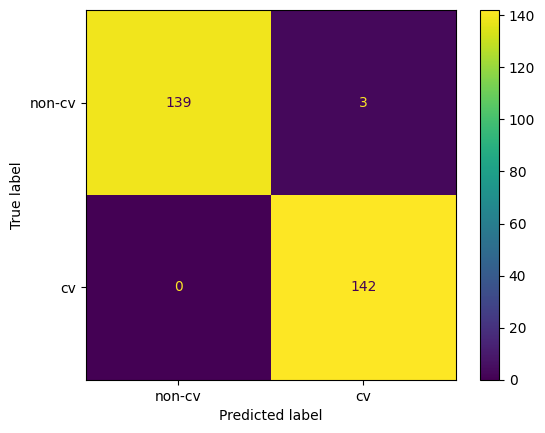

In [90]:
import matplotlib.pyplot as plt
cm_display.plot()
plt.show()

In [ ]:
ngrok.kill()